# Light Curve Fitting with ExoCTK
ExoCTK performs light curve fitting with the `ExoCTK.lightcurve_fitting` tool. This notebook will show you how to do it. 

First, some imports and a toy light curve to work with:

In [221]:
# Imports
import numpy as np
from ExoCTK.lightcurve_fitting.lightcurve import LightCurve
from ExoCTK.lightcurve_fitting.parameters import Parameters
from ExoCTK.lightcurve_fitting.models import Model, PolynomialModel
%matplotlib inline

In [222]:
# Toy data
time = np.arange(100)
raw_flux = [0.9 if 25<i<75 else 1 for i in range(100)]
flux = np.random.normal(raw_flux, scale=0.01)
flux[70:75] *= np.linspace(1, 1.1, 5)
unc = np.random.normal(size=100, scale=0.01)

# Put a gap in the data
idx, = np.where(np.logical_or(time<20,time>30))
time, flux, unc = [arr[idx] for arr in [time, flux, unc]]

## Create a light curve
Creating a light curve instance is simple. Just pass `ExoCTK.lightcurve_fitting.lightcurve.LightCurve()` a `time` and `flux` array. You can also pass it the associated uncertainty with the `unc` argument.

The `units` argument is just the units of the given time axis, in this case 'day'.

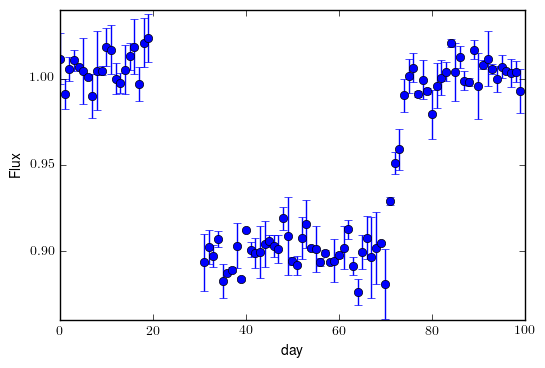

In [227]:
# Instantiate a lightcurve
lc = LightCurve(time, flux, unc, units='day')
lc.plot()

## Create some models to fit to the light curve
Now that we have our light curve data loaded, let's create some models to fit to it.

We can create an arbitrary model with the `ExoCTK.lightcurve_fitting.models.Model()` class by passing it a `time` axis and `flux` axis.

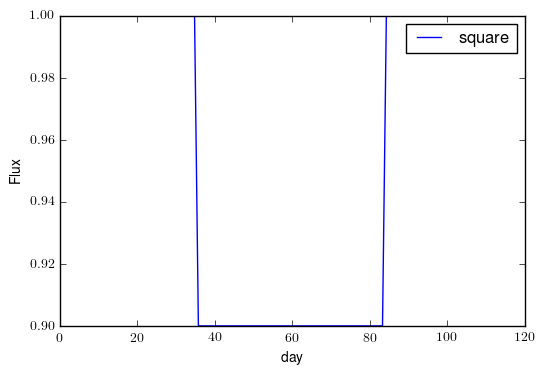

In [228]:
# Create a model
my_model = Model(time=np.linspace(10, 108, 100), flux=raw_flux, name='square')
my_model.plot()

Or we can use one of the many supported models by calling them directly. We'll create a simple linear model using the `PolynomialModel` class.

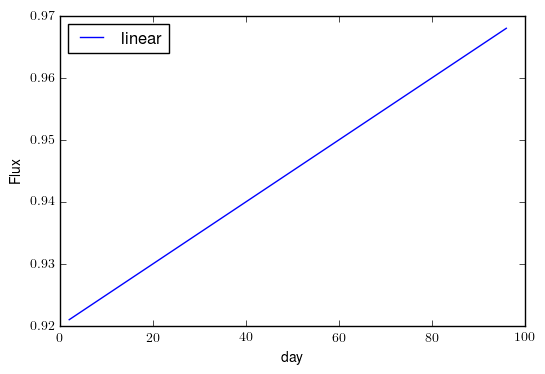

In [225]:
# Create a PolynomialModel instance with coeffs [c1, c0]
lin_model = PolynomialModel(np.linspace(2, 96, 100), [0.0005,0.92], name='linear')
lin_model.plot()

An arbitrary number of models can then be multiplied to produce a final model to fit to the data.

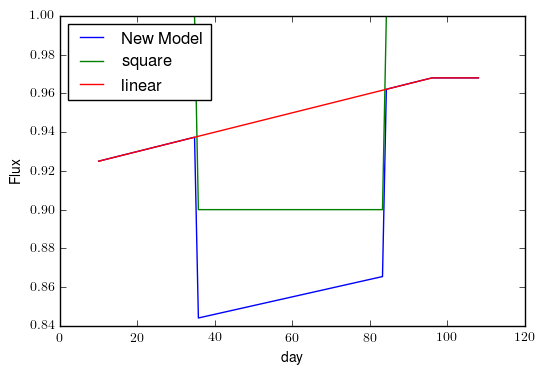

In [226]:
# Make a new model by multiplying some model components (which don't necessarily overlap)
model = my_model*lin_model
model.plot(components=True)

## Fit the model to the light curve data

In [219]:
# Fit the model to the data
lc.fit(my_model, fitter='lmfit')

'lmfit'